In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ipyvolume as ipv
from ipywidgets import FloatProgress
from IPython.display import display, Image


from tyssue import Sheet
from tyssue.draw import sheet_view, browse_history
from tyssue.geometry.bulk_geometry import ClosedMonolayerGeometry as geom
from tyssue.io import hdf5
from tyssue.dynamics import model_factory, effectors
from tyssue.generation.shapes import spherical_monolayer

from tyssue.behaviors import EventManager
from tyssue.behaviors import increase, decrease, reconnect
from tyssue.solvers.viscous import EulerSolver
from tyssue.utils.decorators import face_lookup


from tyssue.draw import highlight_faces, create_gif
from tyssue.solvers.quasistatic import QSSolver

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units


from tyssue import HistoryHdf5



Reference: https://elifesciences.org/articles/32943



I count approx 60 cells in a perimeter of the spherical follicle at stage 5


That means we have a radius of $R = 60 / 2\pi \approx 10$ cells, and $4\pi R^2$ or about 1200 cells in total over the follicle surface.

It is conveninent to consider that cells have an average surface of 1

In [102]:
follicle = spherical_monolayer(9., 12., 1200, apical='in')

geom.update_all(follicle)
geom.scale(follicle, follicle.cell_df.vol.mean()**(-1/3), list("xyz"))
geom.update_all(follicle)

print(f"Follicle has {follicle.Nc} cells")

Follicle has 1252 cells


In [126]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [104]:
ipv.clear()
follicle.face_df['visible'] = (follicle.face_df['y'] > 0) | (follicle.face_df['x'] > 0)
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [105]:
bck0 = follicle.copy()

In [141]:
follicle = bck0.copy()

model = model_factory([
    effectors.LumenVolumeElasticity,
    effectors.FaceAreaElasticity,
    effectors.PerimeterElasticity,
    effectors.CellVolumeElasticity,
    effectors.CellAreaElasticity,
    ])



specs = {
    'cell': {
        'is_alive': 1,
        'area_elasticity': 0.1,
        'prefered_area': follicle.cell_df.area.mean()*0.8,
        'vol_elasticity': 1.0,
        'prefered_vol': 1.0
    },
    'face': {
        'is_alive': 1,
        'area_elasticity': 1.0,
        'prefered_area': 1.0,
        'perimeter_elasticity': 0.1,
        'prefered_perimeter': 3.81,
    },
    'settings': {
        'lumen_vol_elasticity': 1e-2/ follicle.Nc,
        'lumen_prefered_vol': follicle.settings['lumen_vol'],
    }
}

follicle.update_specs(specs, reset=True)

follicle.face_df.loc[follicle.basal_faces, 'perimeter_elasticity'] = 0.0
follicle.face_df.loc[follicle.basal_faces, 'area_elasticity'] = 0
follicle.face_df.loc[follicle.lateral_faces, 'perimeter_elasticity'] = 0.0
follicle.face_df.loc[follicle.lateral_faces, 'area_elasticity'] = 0

A0 = follicle.face_df.loc[follicle.apical_faces, 'area'].mean()
follicle.face_df.loc[follicle.apical_faces, 'prefered_area'] = A0
follicle.face_df.loc[follicle.apical_faces, 'prefered_perimeter'] = 3.81 * A0**0.5



Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs


In [142]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)



b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [143]:
ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [144]:
def contractility_grad_along_z(z, z_a=10, ant_increase=6, post_increase=6):
    """Returns the amplitude of the gradient for z 
    (along the posterior-anterior axis of the follicle).
    
    The gradient is modeled as a quadratic function of z, such that the increase in
    contractility is equal to ant_increase at z_a and to post_increase at -z_a.
    
    """
    
    # we look for a quadradic function with C(-z_a) = ant_increase, C(z_a) = post_increase
    # and C(z_min) = 0 - we find the correct coefs p2, p1 and p0 bellow
    
    app = ant_increase + post_increase
    amp = ant_increase - post_increase
    if amp == 0.:
        p2 = ant_increase / z_a**2
        p1 = 0
        p0 = 0
    else:
        p1 = amp / (2 * z_a)
        inv_poly = [2*z_a**2, -app, p1**2]
        p2_0, p2_1 = np.poly1d(inv_poly).roots
        if isinstance(p2_0, np.complex):
            p2_0, p2_1 = np.real([p2_0, p2_1])
        p2 = p2_0 if p2_0 >= 0 else p2_1
        p0 = p1**2 / (4*p2)

    poly = np.poly1d([p2, p1, p0])
    return np.polyval(poly, z)

def contractility_grad(follicle, cell, amp, span, coords=['x', 'y', 'z']):
    
    cell_pos = follicle.cell_df.loc[cell, coords].to_numpy()
    distance = np.linalg.norm(
        follicle.face_df[coords] - cell_pos[None, :],
        axis=1)
    
    grad = amp * np.exp(-distance / span)
    return grad - grad.min()


In [145]:
bck1 = follicle.copy()

In [155]:
follicle = bck1.copy()

anterior_cell = follicle.cell_df['z'].idxmin() 
posterior_cell = follicle.cell_df['z'].idxmax() 

follicle.face_df["contractile_grad"] = 1 + (
    contractility_grad(follicle, anterior_cell, amp=6, span=2)
    + contractility_grad(follicle, posterior_cell, amp=6, span=2)
)

follicle.face_df["prefered_area"] /= follicle.face_df["contractile_grad"]
follicle.face_df["prefered_perimeter"] /= follicle.face_df["contractile_grad"]**0.5


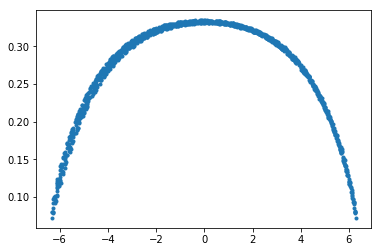

In [156]:
fig, ax = plt.subplots()
ax.plot(
    follicle.face_df.loc[follicle.apical_faces, 'z'],
    follicle.face_df.loc[follicle.apical_faces, 'prefered_area'], '.')

In [157]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['contractile_grad']
    },
}


In [158]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [159]:

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

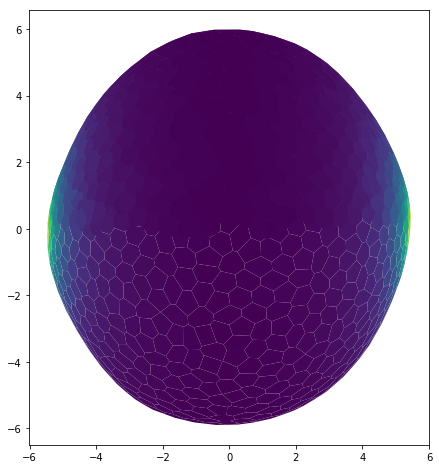

In [161]:
fig, ax = sheet_view(follicle.get_sub_sheet('apical'), mode="2D", coords=["z", "x"], **draw_specs)
fig.set_size_inches(8, 8)

### Increasing lumen volume





In [162]:
follicle.settings['lumen_prefered_vol'] *= 2.


In [163]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [164]:

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…